# Text preprocessing - Pipeline

This code will preprocess a pair of documents in order to analyse their similarity afterwards.

Import libraries

In [3]:
import pandas as pd
import json
import nltk
#nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


Read files

In [4]:
pd.set_option('display.max_colwidth', -1)
## dfSourceV2 = pd.read_csv('../Dados/v2_semeval-2022_task8_train-data_batch.csv')
trainv1 = pd.read_csv('dados/train v0.1.csv')

trainv1_enen = trainv1[(trainv1['url1_lang']=='en') & (trainv1['url2_lang']=='en')]

trainv1_enen.head()

C:\Users\lucas\AppData\Local\Temp/ipykernel_8904/4022916483.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,url1_lang,url2_lang,pair_id,link1,link2,ia_link1,ia_link2,Geography,Entities,Time,Narrative,Overall,Style,Tone
0,en,en,1484084337_1484110209,https://www.washingtonpost.com/local/virginia-man-arrested-in-fatal-dui-crash-in-west-virginia/2020/01/01/740fbc7a-2cbe-11ea-bffe-020c88b3f120_story.html,https://www.washingtonpost.com/world/the_americas/haitis-leader-marks-independence-day-amid-security-concerns/2020/01/01/dc4033a4-2cc5-11ea-bffe-020c88b3f120_story.html,https://web.archive.org/web/www.washingtonpost.com/local/virginia-man-arrested-in-fatal-dui-crash-in-west-virginia/2020/01/01/740fbc7a-2cbe-11ea-bffe-020c88b3f120_story.html,https://web.archive.org/web/www.washingtonpost.com/world/the_americas/haitis-leader-marks-independence-day-amid-security-concerns/2020/01/01/dc4033a4-2cc5-11ea-bffe-020c88b3f120_story.html,4.0,4.000000,1.000000,4.000000,4.000000,1.666667,2.000000
1,en,en,1484396422_1483924666,https://www.stlucianewsonline.com/guyana-three-injured-after-car-crashes-into-utility-pole/,https://www.thestar.com/news/world/europe/2020/01/01/fire-kills-animals-at-zoo-in-western-germany.html,https://web.archive.org/web/www.stlucianewsonline.com/guyana-three-injured-after-car-crashes-into-utility-pole/,https://web.archive.org/web/www.thestar.com/news/world/europe/2020/01/01/fire-kills-animals-at-zoo-in-western-germany.html,4.0,4.000000,1.000000,4.000000,3.666667,1.666667,1.333333
2,en,en,1484698254_1483758694,https://www.teaparty.org/trump-brings-in-2020-at-mar-a-lago-were-going-to-have-a-great-year-423052/,https://www.timesofisrael.com/trump-says-he-does-not-expect-war-with-iran-likes-peace/,https://web.archive.org/web/www.teaparty.org/trump-brings-in-2020-at-mar-a-lago-were-going-to-have-a-great-year-423052/,https://web.archive.org/web/www.timesofisrael.com/trump-says-he-does-not-expect-war-with-iran-likes-peace/,1.0,2.000000,1.000000,2.333333,2.333333,1.000000,1.333333
3,en,en,1576314516_1576455088,https://gadgets.ndtv.com/apps/news/zomato-uber-eats-business-acquisition-india-all-stock-deal-2167155,https://gadgets.ndtv.com/internet/news/indian-online-food-delivery-market-to-hit-usd-8-billion-by-2020-google-bcg-report-2171043,https://web.archive.org/web/gadgets.ndtv.com/apps/news/zomato-uber-eats-business-acquisition-india-all-stock-deal-2167155,https://web.archive.org/web/gadgets.ndtv.com/internet/news/indian-online-food-delivery-market-to-hit-usd-8-billion-by-2020-google-bcg-report-2171043,1.0,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667
4,en,en,1484036253_1483894099,https://news.yahoo.com/india-approves-third-moon-mission-085759387.html,https://www.channelnewsasia.com/news/asia/india-targets-new-moon-mission-in-2020-12225344,https://web.archive.org/web/news.yahoo.com/india-approves-third-moon-mission-085759387.html,https://web.archive.org/web/www.channelnewsasia.com/news/asia/india-targets-new-moon-mission-in-2020-12225344,1.0,1.250000,1.000000,1.250000,1.250000,1.000000,1.000000


### Carregar noticias a partir dos ids:

Functions that read json documents

In [5]:
#Function reads a json file
def readJsonFile(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

    
#Function returns a dataframe with the text of the pairs
def getJsonDocumentPair(dataPath, pairId):
    listIds = pairId.split('_')
    doc1Id = listIds[0]
    doc2Id = listIds[1]

    doc1Path = dataPath + doc1Id[-2:] + '/' + doc1Id + '.json' 
    doc2Path = dataPath + doc2Id[-2:] + '/' + doc2Id + '.json' 

    doc1Json = readJsonFile(doc1Path)
    doc2Json = readJsonFile(doc2Path)

    return (doc1Json, doc2Json)

Getting text to preprocess

In [6]:
dataPath = 'dados/train v0.1/'
#jsonPair = getJsonDocumentPair(dataPath,'1484084337_1484110209')
#textDoc1 = jsonPair[0]['text']

lista_docs = []
lista_error = []
lista_vazio = []
values = trainv1_enen[['pair_id', 'Overall']]

for index, values in values.iterrows():
    try:
        jsonPair = getJsonDocumentPair(dataPath, values['pair_id'])
        textDoc1 = jsonPair[0]['text']
        textDoc2 = jsonPair[1]['text']
        if len(textDoc1)>0 and len(textDoc2)>0:
            lista_docs.append((values['pair_id'], textDoc1, textDoc2, values['Overall']))
        else:
            lista_vazio.append(values['pair_id'])
    except:
        lista_error.append(values['pair_id'])

#Creating DF to text
#dfText = pd.DataFrame([[textDoc1]], columns=['original_text'])
dfText = pd.DataFrame(lista_docs,  columns=['pair_id', 'doc1', 'doc2', 'Overall'])
dfText.head(1)

,pair_id,doc1,doc2,Overall
0,1484084337_1484110209,"MARTINSBURG, W.Va. — A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia, police said.\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County, The Journal reported.\n\nCody Wade Braithwaite, 32, of Winchester, Virginia, was charged with DUI with death, fleeing DUI, and being a prohibited person in possession of a firearm and a fugitive from justice, Berkeley County Sheriff Curtis Keller said.\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop, but the suspect’s vehicle sped up and hit a car, which then struck a guardrail. The driver of the car was pronounced dead at the scene. The driver’s name was not immediately released.\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped, Keller said.\n\nBraithwaite was being held without bond in the Eastern Regional Jail. It wasn’t immediately known whether Braithwaite has an attorney.\n\n___\n\nInformation from: The Journal, http://journal-news.net/\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.","PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil.\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment.\n\n“We’re still extremely poor,” he said. “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself.”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined.\n\nThe speech that marked the 216th anniversary of the world’s first black republic was originally slated to take place in the northern coastal town of Gonaives, where Jean-Jacques Dessalines declared Haiti’s independence. But the town, like many others, was hit by violent protests that began in September amid anger over corruption, fuel shortages and dwindling food supplies as opposition leaders and supporters demanded the resignation of Moïse. More than 40 people have been killed and dozens injured.\n\nLarge-scale protests in Port-au-Prince have since dissipated, although smaller ones are still occurring elsewhere in the country. On Wednesday, opposition leaders and supporters gathered in Gonaives to attend the funeral of an anti-government protester and then carried his coffin through the streets as more protesters joined them.\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.",4.0


In [7]:
dfText.shape


(1357, 4)

In [8]:
trainv1_enen.shape

(1761, 14)

In [9]:
len(lista_error)

394

In [10]:
len(lista_vazio)

10

# Inicio do pre-processamento

Removing punctuation

In [11]:
import string
string.punctuation
other_punctuation = '—“”'  

In [12]:
#Function that removes punctuation 
def removePunctuation(text):
    punctuationFreeDoc = "".join([i for i in text if i not in string.punctuation+other_punctuation])
    return punctuationFreeDoc


#Storing the puntuation free text
dfText['clean_msg1']= dfText['doc1'].apply(lambda x:removePunctuation(x))
dfText['clean_msg2']= dfText['doc2'].apply(lambda x:removePunctuation(x))
dfText.head(1)

,pair_id,doc1,doc2,Overall,clean_msg1,clean_msg2
0,1484084337_1484110209,"MARTINSBURG, W.Va. — A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia, police said.\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County, The Journal reported.\n\nCody Wade Braithwaite, 32, of Winchester, Virginia, was charged with DUI with death, fleeing DUI, and being a prohibited person in possession of a firearm and a fugitive from justice, Berkeley County Sheriff Curtis Keller said.\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop, but the suspect’s vehicle sped up and hit a car, which then struck a guardrail. The driver of the car was pronounced dead at the scene. The driver’s name was not immediately released.\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped, Keller said.\n\nBraithwaite was being held without bond in the Eastern Regional Jail. It wasn’t immediately known whether Braithwaite has an attorney.\n\n___\n\nInformation from: The Journal, http://journal-news.net/\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.","PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil.\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment.\n\n“We’re still extremely poor,” he said. “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself.”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined.\n\nThe speech that marked the 216th anniversary of the world’s first black republic was originally slated to take place in the northern coastal town of Gonaives, where Jean-Jacques Dessalines declared Haiti’s independence. But the town, like many others, was hit by violent protests that began in September amid anger over corruption, fuel shortages and dwindling food supplies as opposition leaders and supporters demanded the resignation of Moïse. More than 40 people have been killed and dozens injured.\n\nLarge-scale protests in Port-au-Prince have since dissipated, although smaller ones are still occurring elsewhere in the country. On Wednesday, opposition leaders and supporters gathered in Gonaives to attend the funeral of an anti-government protester and then carried his coffin through the streets as more protesters joined them.\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.",4.0,MARTINSBURG WVa A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia police said\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County The Journal reported\n\nCody Wade Braithwaite 32 of Winchester Virginia was charged with DUI with death fleeing DUI and being a prohibited person in possession of a firearm and a fugitive from justice Berkeley County Sheriff Curtis Keller said\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop but the suspect’s vehicle sped up and hit a car which then struck a guardrail The driver of the car was pronounced dead at the scene The driver’s name was not immediately released\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped 

Transforming to lowercase

In [13]:
dfText['msg_lower1']= dfText['clean_msg1'].apply(lambda x: x.lower())
dfText['msg_lower2']= dfText['clean_msg2'].apply(lambda x: x.lower())
dfText.head(1)

,pair_id,doc1,doc2,Overall,clean_msg1,clean_msg2,msg_lower1,msg_lower2
0,1484084337_1484110209,"MARTINSBURG, W.Va. — A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia, police said.\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County, The Journal reported.\n\nCody Wade Braithwaite, 32, of Winchester, Virginia, was charged with DUI with death, fleeing DUI, and being a prohibited person in possession of a firearm and a fugitive from justice, Berkeley County Sheriff Curtis Keller said.\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop, but the suspect’s vehicle sped up and hit a car, which then struck a guardrail. The driver of the car was pronounced dead at the scene. The driver’s name was not immediately released.\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped, Keller said.\n\nBraithwaite was being held without bond in the Eastern Regional Jail. It wasn’t immediately known whether Braithwaite has an attorney.\n\n___\n\nInformation from: The Journal, http://journal-news.net/\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.","PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil.\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment.\n\n“We’re still extremely poor,” he said. “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself.”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined.\n\nThe speech that marked the 216th anniversary of the world’s first black republic was originally slated to take place in the northern coastal town of Gonaives, where Jean-Jacques Dessalines declared Haiti’s independence. But the town, like many others, was hit by violent protests that began in September amid anger over corruption, fuel shortages and dwindling food supplies as opposition leaders and supporters demanded the resignation of Moïse. More than 40 people have been killed and dozens injured.\n\nLarge-scale protests in Port-au-Prince have since dissipated, although smaller ones are still occurring elsewhere in the country. On Wednesday, opposition leaders and supporters gathered in Gonaives to attend the funeral of an anti-government protester and then carried his coffin through the streets as more protesters joined them.\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.",4.0,MARTINSBURG WVa A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia police said\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County The Journal reported\n\nCody Wade Braithwaite 32 of Winchester Virginia was charged with DUI with death fleeing DUI and being a prohibited person in possession of a firearm and a fugitive from justice Berkeley County Sheriff Curtis Keller said\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop but the suspect’s vehicle sped up and hit a car which then struck a guardrail The driver of the car was pronounced dead at the scene The driver’s name was not immediately released\n\nThe suspect’s vehicle also hit a deputy’s cruiser

Tokenization

In [14]:
dfText['msg_tokenized1']= dfText['msg_lower1'].apply(lambda x: nltk.word_tokenize(x))
dfText['msg_tokenized2']= dfText['msg_lower2'].apply(lambda x: nltk.word_tokenize(x))
dfText.head(1)

,pair_id,doc1,doc2,Overall,clean_msg1,clean_msg2,msg_lower1,msg_lower2,msg_tokenized1,msg_tokenized2
0,1484084337_1484110209,"MARTINSBURG, W.Va. — A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia, police said.\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County, The Journal reported.\n\nCody Wade Braithwaite, 32, of Winchester, Virginia, was charged with DUI with death, fleeing DUI, and being a prohibited person in possession of a firearm and a fugitive from justice, Berkeley County Sheriff Curtis Keller said.\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop, but the suspect’s vehicle sped up and hit a car, which then struck a guardrail. The driver of the car was pronounced dead at the scene. The driver’s name was not immediately released.\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped, Keller said.\n\nBraithwaite was being held without bond in the Eastern Regional Jail. It wasn’t immediately known whether Braithwaite has an attorney.\n\n___\n\nInformation from: The Journal, http://journal-news.net/\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.","PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil.\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment.\n\n“We’re still extremely poor,” he said. “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself.”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined.\n\nThe speech that marked the 216th anniversary of the world’s first black republic was originally slated to take place in the northern coastal town of Gonaives, where Jean-Jacques Dessalines declared Haiti’s independence. But the town, like many others, was hit by violent protests that began in September amid anger over corruption, fuel shortages and dwindling food supplies as opposition leaders and supporters demanded the resignation of Moïse. More than 40 people have been killed and dozens injured.\n\nLarge-scale protests in Port-au-Prince have since dissipated, although smaller ones are still occurring elsewhere in the country. On Wednesday, opposition leaders and supporters gathered in Gonaives to attend the funeral of an anti-government protester and then carried his coffin through the streets as more protesters joined them.\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.",4.0,MARTINSBURG WVa A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia police said\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County The Journal reported\n\nCody Wade Braithwaite 32 of Winchester Virginia was charged with DUI with death fleeing DUI and being a prohibited person in possession of a firearm and a fugitive from justice Berkeley County Sheriff Curtis Keller said\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop but the suspect’s vehicle sped up and hit a car which then struck a guardrail The driver of the car was pronounced dead at the scene The driver’s name was not immediately released\n\nThe suspect’s vehic

Talvez fazer o sentence tokenizer:

Stopwords filtering

In [15]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.append('’')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
def removeStopwords(listWords):
    filteredWords = [word for word in listWords if word not in stop_words]
    return filteredWords

dfText['no_stopwords1']= dfText['msg_tokenized1'].apply(lambda x: removeStopwords(x))
dfText['no_stopwords2']= dfText['msg_tokenized2'].apply(lambda x: removeStopwords(x))
dfText[['msg_tokenized1', 'no_stopwords1', 'msg_tokenized2', 'no_stopwords2']].head(1)


,msg_tokenized1,no_stopwords1,msg_tokenized2,no_stopwords2
0,"[martinsburg, wva, a, suspected, drunken, driver, was, arrested, in, a, new, year, ’, s, day, highway, crash, that, killed, another, motorist, in, west, virginia, police, said, the, accident, occurred, early, wednesday, along, southbound, interstate, 81, in, berkeley, county, the, journal, reported, cody, wade, braithwaite, 32, of, winchester, virginia, was, charged, with, dui, with, death, fleeing, dui, and, being, a, prohibited, person, in, possession, of, a, firearm, and, a, fugitive, from, justice, berkeley, county, sheriff, curtis, keller, said, keller, said, a, deputy, investigating, calls, about, a, reckless, driver, attempted, to, make, a, traffic, stop, but, the, suspect, ’, s, vehicle, sped, ...]","[martinsburg, wva, suspected, drunken, driver, arrested, new, year, day, highway, crash, killed, another, motorist, west, virginia, police, said, accident, occurred, early, wednesday, along, southbound, interstate, 81, berkeley, county, journal, reported, cody, wade, braithwaite, 32, winchester, virginia, charged, dui, death, fleeing, dui, prohibited, person, possession, firearm, fugitive, justice, berkeley, county, sheriff, curtis, keller, said, keller, said, deputy, investigating, calls, reckless, driver, attempted, make, traffic, stop, suspect, vehicle, sped, hit, car, struck, guardrail, driver, car, pronounced, dead, scene, driver, name, immediately, released, suspect, vehicle, also, hit, deputy, cruiser, stopped, keller, said, braithwaite, held, without, bond, eastern, regional, jail, immediately, known, whether, braithwaite, ...]","[portauprince, haiti, haitian, president, jovenel, moïse, broke, with, tradition, on, wednesday, and, celebrated, the, country, ’, s, independence, day, in, the, capital, for, security, reasons, following, months, of, political, turmoil, moïse, whose, government, has, been, accused, of, corruption, denounced, graft, during, his, speech, at, the, national, palace, in, portauprince, and, urged, haiti, ’, s, elite, to, work, with, the, government, and, help, create, employment, we, ’, re, still, extremely, poor, he, said, those, who, continue, to, get, rich, find, it, normal, that, they, do, not, pay, taxes, find, it, normal, that, there, can, be, no, competition, find, it, normal, that, ...]","[portauprince, haiti, haitian, president, jovenel, moïse, broke, tradition, wednesday, celebrated, country, independence, day, capital, security, reasons, following, months, political, turmoil, moïse, whose, government, accused, corruption, denounced, graft, speech, national, palace, portauprince, urged, haiti, elite, work, government, help, create, employment, still, extremely, poor, said, continue, get, rich, find, normal, pay, taxes, find, normal, competition, find, normal, set, prices, consumers, especially, consumer, state, moïse, also, apologized, country, ongoing, power, outages, renewed, 2016, campaign, pledge, provide, electricity, 24, hours, day, saying, harder, accomplish, imagined, speech, marked, 216th, anniversary, world, first, black, republic, originally, slated, take, place, northern, coastal, town, gonaives, jeanjacques, dessalines, declared, ...]"


Stemming

In [17]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def stemming(listWords):
    stemText = [porter.stem(word) for word in listWords]
    return stemText

dfText['msg_stemmed1']= dfText['no_stopwords1'].apply(lambda x: stemming(x))
dfText['msg_stemmed2']= dfText['no_stopwords2'].apply(lambda x: stemming(x))
dfText[['no_stopwords1', 'msg_stemmed1', 'no_stopwords2', 'msg_stemmed2']].head(1)

,no_stopwords1,msg_stemmed1,no_stopwords2,msg_stemmed2
0,"[martinsburg, wva, suspected, drunken, driver, arrested, new, year, day, highway, crash, killed, another, motorist, west, virginia, police, said, accident, occurred, early, wednesday, along, southbound, interstate, 81, berkeley, county, journal, reported, cody, wade, braithwaite, 32, winchester, virginia, charged, dui, death, fleeing, dui, prohibited, person, possession, firearm, fugitive, justice, berkeley, county, sheriff, curtis, keller, said, keller, said, deputy, investigating, calls, reckless, driver, attempted, make, traffic, stop, suspect, vehicle, sped, hit, car, struck, guardrail, driver, car, pronounced, dead, scene, driver, name, immediately, released, suspect, vehicle, also, hit, deputy, cruiser, stopped, keller, said, braithwaite, held, without, bond, eastern, regional, jail, immediately, known, whether, braithwaite, ...]","[martinsburg, wva, suspect, drunken, driver, arrest, new, year, day, highway, crash, kill, anoth, motorist, west, virginia, polic, said, accid, occur, earli, wednesday, along, southbound, interst, 81, berkeley, counti, journal, report, codi, wade, braithwait, 32, winchest, virginia, charg, dui, death, flee, dui, prohibit, person, possess, firearm, fugit, justic, berkeley, counti, sheriff, curti, keller, said, keller, said, deputi, investig, call, reckless, driver, attempt, make, traffic, stop, suspect, vehicl, sped, hit, car, struck, guardrail, driver, car, pronounc, dead, scene, driver, name, immedi, releas, suspect, vehicl, also, hit, deputi, cruiser, stop, keller, said, braithwait, held, without, bond, eastern, region, jail, immedi, known, whether, braithwait, ...]","[portauprince, haiti, haitian, president, jovenel, moïse, broke, tradition, wednesday, celebrated, country, independence, day, capital, security, reasons, following, months, political, turmoil, moïse, whose, government, accused, corruption, denounced, graft, speech, national, palace, portauprince, urged, haiti, elite, work, government, help, create, employment, still, extremely, poor, said, continue, get, rich, find, normal, pay, taxes, find, normal, competition, find, normal, set, prices, consumers, especially, consumer, state, moïse, also, apologized, country, ongoing, power, outages, renewed, 2016, campaign, pledge, provide, electricity, 24, hours, day, saying, harder, accomplish, imagined, speech, marked, 216th, anniversary, world, first, black, republic, originally, slated, take, place, northern, coastal, town, gonaives, jeanjacques, dessalines, declared, ...]","[portauprinc, haiti, haitian, presid, jovenel, moïs, broke, tradit, wednesday, celebr, countri, independ, day, capit, secur, reason, follow, month, polit, turmoil, moïs, whose, govern, accus, corrupt, denounc, graft, speech, nation, palac, portauprinc, urg, haiti, elit, work, govern, help, creat, employ, still, extrem, poor, said, continu, get, rich, find, normal, pay, tax, find, normal, competit, find, normal, set, price, consum, especi, consum, state, moïs, also, apolog, countri, ongo, power, outag, renew, 2016, campaign, pledg, provid, electr, 24, hour, day, say, harder, accomplish, imagin, speech, mark, 216th, anniversari, world, first, black, republ, origin, slate, take, place, northern, coastal, town, gonaiv, jeanjacqu, dessalin, declar, ...]"


Lemmatization

In [18]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

#defining the function for lemmatization
def lemmatizer(listWords):
    lemmText = [wordnet_lemmatizer.lemmatize(word) for word in listWords]
    return lemmText

dfText['msg_lemmatized1']= dfText['no_stopwords1'].apply(lambda x: lemmatizer(x))
dfText['msg_lemmatized2']= dfText['no_stopwords2'].apply(lambda x: lemmatizer(x))
dfText[['no_stopwords1', 'msg_lemmatized1']].head(1)

,no_stopwords1,msg_lemmatized1
0,"[martinsburg, wva, suspected, drunken, driver, arrested, new, year, day, highway, crash, killed, another, motorist, west, virginia, police, said, accident, occurred, early, wednesday, along, southbound, interstate, 81, berkeley, county, journal, reported, cody, wade, braithwaite, 32, winchester, virginia, charged, dui, death, fleeing, dui, prohibited, person, possession, firearm, fugitive, justice, berkeley, county, sheriff, curtis, keller, said, keller, said, deputy, investigating, calls, reckless, driver, attempted, make, traffic, stop, suspect, vehicle, sped, hit, car, struck, guardrail, driver, car, pronounced, dead, scene, driver, name, immediately, released, suspect, vehicle, also, hit, deputy, cruiser, stopped, keller, said, braithwaite, held, without, bond, eastern, regional, jail, immediately, known, whether, braithwaite, ...]","[martinsburg, wva, suspected, drunken, driver, arrested, new, year, day, highway, crash, killed, another, motorist, west, virginia, police, said, accident, occurred, early, wednesday, along, southbound, interstate, 81, berkeley, county, journal, reported, cody, wade, braithwaite, 32, winchester, virginia, charged, duo, death, fleeing, duo, prohibited, person, possession, firearm, fugitive, justice, berkeley, county, sheriff, curtis, keller, said, keller, said, deputy, investigating, call, reckless, driver, attempted, make, traffic, stop, suspect, vehicle, sped, hit, car, struck, guardrail, driver, car, pronounced, dead, scene, driver, name, immediately, released, suspect, vehicle, also, hit, deputy, cruiser, stopped, keller, said, braithwaite, held, without, bond, eastern, regional, jail, immediately, known, whether, braithwaite, ...]"


## Implementação dos algoritmos

### Jaccard

In [19]:
def calculate_jaccard(word_tokens1, word_tokens2):
	# Combine both tokens to find union.
	both_tokens = word_tokens1 + word_tokens2
	union = set(both_tokens)

	# Calculate intersection.
	intersection = set()
	for w in word_tokens1:
		if w in word_tokens2:
			intersection.add(w)

	if len(union)==0:
		jaccard_score = 0
	else:
		jaccard_score = len(intersection)/len(union)
	return jaccard_score

In [20]:
dfText['jaccard'] = dfText.apply(lambda row: calculate_jaccard(row['msg_lemmatized1'], row['msg_lemmatized2']), axis=1)
#calculate_jaccard(dfText['msg_lemmatized1'][0], dfText['msg_lemmatized2'][0])

In [21]:
dfText[['jaccard', 'Overall']]

,jaccard,Overall
0,0.082569,4.000000
1,0.042254,3.666667
2,0.114894,2.333333
3,0.133127,2.000000
4,0.204348,1.250000
...,...,...
1352,0.118750,1.000000
1353,0.378109,1.000000
1354,0.128736,4.000000
1355,0.201005,1.000000


### TF-IDF

In [22]:
dfText.head(1)

,pair_id,doc1,doc2,Overall,clean_msg1,clean_msg2,msg_lower1,msg_lower2,msg_tokenized1,msg_tokenized2,no_stopwords1,no_stopwords2,msg_stemmed1,msg_stemmed2,msg_lemmatized1,msg_lemmatized2,jaccard
0,1484084337_1484110209,"MARTINSBURG, W.Va. — A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia, police said.\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County, The Journal reported.\n\nCody Wade Braithwaite, 32, of Winchester, Virginia, was charged with DUI with death, fleeing DUI, and being a prohibited person in possession of a firearm and a fugitive from justice, Berkeley County Sheriff Curtis Keller said.\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop, but the suspect’s vehicle sped up and hit a car, which then struck a guardrail. The driver of the car was pronounced dead at the scene. The driver’s name was not immediately released.\n\nThe suspect’s vehicle also hit a deputy’s cruiser before being stopped, Keller said.\n\nBraithwaite was being held without bond in the Eastern Regional Jail. It wasn’t immediately known whether Braithwaite has an attorney.\n\n___\n\nInformation from: The Journal, http://journal-news.net/\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.","PORT-AU-PRINCE, Haiti — Haitian President Jovenel Moïse broke with tradition on Wednesday and celebrated the country’s independence day in the capital for security reasons following months of political turmoil.\n\nMoïse, whose government has been accused of corruption, denounced graft during his speech at the National Palace in Port-au-Prince and urged Haiti’s elite to work with the government and help create employment.\n\n“We’re still extremely poor,” he said. “Those who continue to get rich find it normal that they do not pay taxes, find it normal that there can be no competition, find it normal that they set prices for consumers, especially when this consumer is the state itself.”\n\nMoïse also apologized for the country’s ongoing power outages and renewed his 2016 campaign pledge to provide electricity 24 hours a day, saying it was harder to accomplish than he imagined.\n\nThe speech that marked the 216th anniversary of the world’s first black republic was originally slated to take place in the northern coastal town of Gonaives, where Jean-Jacques Dessalines declared Haiti’s independence. But the town, like many others, was hit by violent protests that began in September amid anger over corruption, fuel shortages and dwindling food supplies as opposition leaders and supporters demanded the resignation of Moïse. More than 40 people have been killed and dozens injured.\n\nLarge-scale protests in Port-au-Prince have since dissipated, although smaller ones are still occurring elsewhere in the country. On Wednesday, opposition leaders and supporters gathered in Gonaives to attend the funeral of an anti-government protester and then carried his coffin through the streets as more protesters joined them.\n\nCopyright 2020 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed.",4.0,MARTINSBURG WVa A suspected drunken driver was arrested in a New Year’s Day highway crash that killed another motorist in West Virginia police said\n\nThe accident occurred early Wednesday along southbound Interstate 81 in Berkeley County The Journal reported\n\nCody Wade Braithwaite 32 of Winchester Virginia was charged with DUI with death fleeing DUI and being a prohibited person in possession of a firearm and a fugitive from justice Berkeley County Sheriff Curtis Keller said\n\nKeller said a deputy investigating calls about a reckless driver attempted to make a traffic stop but the suspect’s vehicle sped up and hit a car which then struck a guardrail The driver of the car was pron

In [23]:
def process_tfidf_similarity():
	vectorizer = TfidfVectorizer()

	# To make uniformed vectors, both documents need to be combined first.
	documents.insert(0, base_document)
	embeddings = vectorizer.fit_transform(documents)

	cosine_similarities = cosine_similarity(embeddings[0:1], embeddings[1:]).flatten()

In [24]:
lista_doc = []
lista_doc.append(' '.join(dfText['no_stopwords1'][4]))
lista_doc.append(' '.join(dfText['no_stopwords2'][4]))
#lista_doc.append(' '.join(dfText['no_stopwords1'][0]))
#lista_doc.append(' '.join(dfText['no_stopwords2'][0]))
#lista_doc.append(dfText['msg_lower1'][1])
#lista_doc.append(dfText['msg_lower2'][1])
#lista_doc.append(dfText['msg_lower1'][0])


In [25]:
lista_doc = []
lista_doc.append(' '.join(dfText['msg_lemmatized1'][4]))
lista_doc.append(' '.join(dfText['msg_lemmatized2'][4]))
lista_doc.append(' '.join(dfText['msg_lemmatized1'][1]))
lista_doc.append(' '.join(dfText['msg_lemmatized2'][1]))
#lista_doc.append(' '.join(dfText['msg_lemmatized1'][2]))
#lista_doc.append(dfText['msg_lower1'][1])
#lista_doc.append(dfText['msg_lower2'][1])
#lista_doc.append(dfText['msg_lower1'][0])


In [26]:
lista_doc = []
lista_doc.append(' '.join(dfText['msg_stemmed1'][4]))
lista_doc.append(' '.join(dfText['msg_stemmed2'][4]))
lista_doc.append(' '.join(dfText['msg_stemmed1'][1]))
lista_doc.append(' '.join(dfText['msg_stemmed2'][1]))

In [27]:
documents = lista_doc
tfidf = TfidfVectorizer().fit_transform(documents)
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf * tfidf.T


In [28]:
pairwise_similarity.toarray()

array([[1.        , 0.4431749 , 0.02683934, 0.07125562],
       [0.4431749 , 1.        , 0.01700037, 0.09405446],
       [0.02683934, 0.01700037, 1.        , 0.04634662],
       [0.07125562, 0.09405446, 0.04634662, 1.        ]])

In [29]:
tfidf.shape

(4, 457)

In [30]:
cosine_similarities = cosine_similarity(tfidf[0:1], tfidf[1:]).flatten()

In [31]:
cosine_similarities

array([0.4431749 , 0.02683934, 0.07125562])

In [32]:
dfText['doc1'][4]

'BENGALURU (Reuters) - India has approved its third lunar mission months after its last one failed to successfully land on the moon, its space agency said on Wednesday, the latest effort in its ambitions to become a low-cost space power.\n\nThe Chandrayaan-3 mission will have a lander and a rover, but not an orbiter, Indian Space Research Organisation (ISRO) Chairman K. Sivan told reporters at its headquarters in Bengaluru, according to an official telecast.\n\nThe Chandrayaan-2 mission in September successfully deployed a lunar orbiter that relays scientific data back to earth, but was unable to place a rover on the lunar surface after a "hard" landing.\n\nThat mission had aimed to land on the south pole of the moon, where no other lunar mission had gone before. The region is believed to contain water as craters in the region are largely unaffected by the high temperatures of the sun.\n\nISRO had hoped to confirm the presence of water in the form of ice, first detected on its mission 

In [33]:
dfText['doc2'][4]

'BANGALORE: India plans to make a fresh attempt to land an unmanned mission on the moon in 2020 after a failed bid last year, the head of the country\'s space programme said on Wednesday (Jan 1).\n\nWork is going "smoothly" on the Chandrayaan-3 mission to put a rover probe on the moon\'s surface, Indian Space Research Organisation chairman K. Sivan told a press conference.\n\nAdvertisement\n\nAdvertisement\n\n"We are targeting the launch for this year but it may spillover to next year," Sivan said. Indian sources said authorities had set November as a provisional target for launch.\n\nIndia seeking to become only the fourth nation after Russia, the United States and China to put a mission on the moon\'s surface and boost its credentials as a low-cost space power.\n\nThe country\'s Chandrayaan-2 module crash-landed on the moon\'s surface in September.\n\nSivan said the new propulsion module, lander and surface rover would cost about US$35 million, with a significantly higher outlay for 

### doc2vec (https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd)

In [128]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec
from scipy import spatial

In [173]:
#data = []
#for i in range(0,len(dfText)):
#    data.append(TaggedDocument(words=dfText['msg_lemmatized1'][i], tags=str(2*i)))
#    data.append(TaggedDocument(words=dfText['msg_lemmatized2'][i], tags=str((2*i)+1)))

In [212]:
data = []
for i in range(0,len(dfText)):
    data.append(' '.join(dfText['no_stopwords1'][i]))
    data.append(' '.join(dfText['no_stopwords2'][i]))

data = list(set(data))

In [213]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)] 

In [214]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=30, min_count=0, epochs=80)

In [215]:
model.build_vocab(tagged_data)

In [216]:
model.train(tagged_data, total_examples=model.corpus_count, epochs=80)

In [217]:
model.save("d2v.model")

In [218]:
model = Doc2Vec.load("d2v.model")

In [226]:
def doc2vec_cos(doc1, doc2):
    infer1 = model.infer_vector(doc1)
    infer2 = model.infer_vector(doc2)
    #cos_distance = spatial.distance.cosine(infer1, infer2) #pode ser >1
    cos_similarity = 1-spatial.distance.cosine(infer1, infer2) #de 0 a 1
    return cos_similarity


In [227]:
dfText['doc2vec'] = dfText.apply(lambda row: doc2vec_cos(row['msg_tokenized1'], row['msg_tokenized2']), axis=1)

In [228]:
dfText[['doc2vec', 'Overall']].head(20)

,doc2vec,Overall
0,0.163313,4.000000
1,0.345179,3.666667
2,0.739915,2.333333
3,0.793537,2.000000
4,0.843488,1.250000
5,0.833278,2.000000
6,0.482899,3.666667
7,0.369662,3.333333
8,0.444346,3.333333
9,0.520542,2.666667


In [229]:
### Proximos passos: definir pipeline, aplicar o metodo para no_stopwords, msg_lemmatized e msg_stemmed.
### Para verificar qual é o melhor método podemos colocar o Overall na mesma escala (0 a 1?) e comparar utilizando
### Alguma métrica
## obs: ver tbm se esta utilizando CBOW ou...

In [236]:
dfText[dfText['doc2vec']<0][['Overall', 'jaccard', 'doc2vec', 'pair_id']]
#dfText[['Overall', 'jaccard', 'doc2vec', 'pair_id']]

,Overall,jaccard,doc2vec,pair_id
449,4.000000,0.043478,-0.010343,1484038971_1484265527
612,3.666667,0.029268,-0.007674,1484698238_1484031932
703,4.000000,0.092874,-0.006559,1484010654_1483806924
1054,4.000000,0.043564,-0.043967,1484188215_1484306920
1086,4.000000,0.032323,-0.026977,1484012606_1484006474
1101,4.000000,0.034783,-0.045366,1496646947_1483988400
1159,4.000000,0.012500,-0.056068,1483805286_1483851278
1236,4.000000,0.033019,-0.111092,1484759070_1484061008
1244,4.000000,0.039409,-0.091383,1484006498_1484249412
1307,4.000000,0.027778,-0.015548,1521216697_1558793253


array([[<AxesSubplot:title={'center':'Overall'}>]], dtype=object)

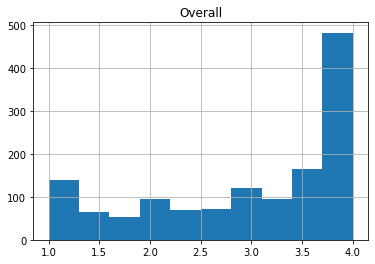

In [235]:
dfText.hist('Overall')

## BERT

## Word2vec (embeddings)